# Actor-Critic Method in Reinforcement Learning

 The Actor-Critic is a combination of value-based, and policy-based methods where the Actor controls how our agent behaves using the Policy gradient, and the Critic evaluates how good the action taken by the Agent based on value-function.

 ![AC](../assets/Actor_Critic.webp)

The Actor-Critic algorithm takes inputs from the environment and uses those states to determine the optimal actions.
The Actor component of the algorithm takes the current state as input from the environment. It uses a neural network, which serves as the policy, to output the probabilities of each action for the state.

The Critic network takes the current state and the Actor’s outputted actions as inputs and uses this information to estimate the expected future reward, also known as the Q-value. The Q-value represents the expected cumulative reward an agent can expect to receive if it follows a certain policy in a given state ($R = \sum_{t = 0}^T \gamma^t r_t$).

![AC-Algo](../assets/Actor_Critic_Algo.webp)


The value state $V(s)$ represents the expected future reward for a given state, regardless of the action taken. It is calculated as the average of all the Q-values for a given state over all possible actions. It is fed from  the Critic network as feedback to the Actor network. 

Imagine that the action-value function Q (whose value is a scalar) had an offset and was only changing between 99 and 100 as we take our steps. It would be better to subtract off this average offset so the change would be between say -0.5 and +0.5. We can subtract a baseline function of state (as long as it has no dependence on action) from Q, and one choice is to use V as the baseline, giving us the so-called advantage function A:

$$ A(a, s) = Q(s,a) - V(s) $$

We are allowed to replace R(s,a) by A(s,a) in the policy gradient because the substraction of the constant V does not change the policy gradient: 
$$\Delta J \approx E[log\Delta\pi(a|s)A(a,s)]$$





In this method, we generate a value-function (which can also be implemented by neural networks) $ V(s) $ and apply policy gradient for an advantage-function $ A(a, s) $. We should then generate 2 functions - value function and policy function - and optimize parameters in these 2 functions.<br>
Intuitively, the value function is optimized for the value estimation in each state, and the policy function is optimized to take an appropriate action in that state.

Remember that we have applied gradient descent on $ E\left[\sum{\gamma r}\right] $ in REINFORCE method. By applying policy gradient on the reduced $ A(a, s) $ instead of $ E\left[\sum{\gamma r}\right] $, we can expect the stable convergence in complex problems, as it has less variance.



In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.output(outs)
        return logits

class ValueNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        value = self.output(outs)
        return value

actor_func = ActorNet().to(device)
value_func = ValueNet().to(device)

Now we optimize both policy gradient loss (following ```pi_loss```) and value loss (following ```vf_loss```) as follows.

In this example,

- Separately optimize actor and critic with policy loss $ p $ (```pi_loss```) and value loss $ v $ (```vf_loss```) respectively. 
- Simply use the cumulative rewards $\sum{\gamma r}$ as an estimated value in batch.


In [3]:
gamma = 0.99

# pick up action with above distribution policy_pi
def pick_sample(s):
    with torch.no_grad():
        #   --> size : (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        # Get logits from state
        #   --> size : (1, 2)
        logits = actor_func(s_batch)
        #   --> size : (2)
        logits = logits.squeeze(dim=0)
        # From logits to probabilities
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        a = torch.multinomial(probs, num_samples=1)
        # Return
        return a.tolist()[0]

env = gym.make("CartPole-v1")
reward_records = []
opt1 = torch.optim.AdamW(value_func.parameters(), lr=0.001)
opt2 = torch.optim.AdamW(actor_func.parameters(), lr=0.001)
for i in range(1500):
    #
    # Run episode till done
    #
    done = False
    states = []
    actions = []
    rewards = []
    s, _ = env.reset()
    while not done:
        states.append(s.tolist())
        a = pick_sample(s)
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        actions.append(a)
        rewards.append(r)

    #
    # Get cumulative rewards
    #
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

    

    # Optimize value loss (Critic)
    opt1.zero_grad()
    states = torch.tensor(states, dtype=torch.float).to(device)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)
    values = value_func(states)
    values = values.squeeze(dim=1)
    vf_loss = F.mse_loss(
        values,
        cum_rewards,
        reduction="none")
    vf_loss.sum().backward()
    opt1.step()

    # Optimize policy loss (Actor)
    with torch.no_grad():
        values = value_func(states)
    opt2.zero_grad()
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    advantages = cum_rewards - values
    logits = actor_func(states)
    log_probs = F.log_softmax(logits,dim = 1)[range(len(states)),actions] 
    pi_loss = -log_probs * advantages
    pi_loss.sum().backward()
    opt2.step()

    # Output total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, sum(rewards)), end="\r")
    reward_records.append(sum(rewards))

    # stop if reward mean > 475.0
    if np.average(reward_records[-50:]) > 475.0:
        break

print("\nDone")
env.close()

Run episode1175 with rewards 500.0
Done


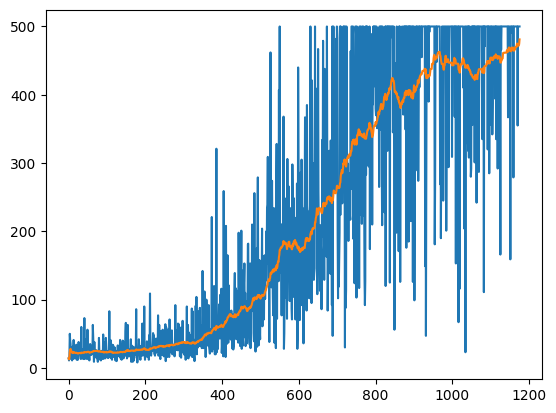

In [4]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)